#### The goal of this project file is to predict flow using ppt data

In [1]:
import pandas as pd
import math
import numpy as np
import sklearn as sk
import sklearn.datasets as skd
import sklearn.ensemble as ske
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from pprint import pprint

%matplotlib inline

In [24]:
# importing flow dataset
df_flow = pd.read_excel('Daily ISCO flow and precipitation.xlsx', sheet_name = 'Sheet1')


df_flow = df_flow.drop(columns=['Daily precip (in)','Daily precip (mm)','S12-ISCO flow (cms)','T12-ISCO flow (cms)'])

df_flow = df_flow.rename(columns={'T8-ISCO flow (cms)':'Flow8', 'S11-ISCO flow (cms)':'Flow11', 'S12+T12':'Flow12'})

#df_flow = pd.DataFrame(df_flow, columns=['Sample date', 'Sample type', 'Site', 'Flow'])

df_flow.head()

,Date,Flow8,Flow11,Flow12
0,2015-01-01,NaN,NaN,NaN
1,2015-01-02,NaN,NaN,NaN
2,2015-01-03,NaN,NaN,NaN
3,2015-01-04,NaN,NaN,NaN
4,2015-01-05,NaN,NaN,NaN


In [3]:
df_base8 = df_flow[(df_flow['Site'] == 'Sub8') & (df_flow['Sample type'] == 'Base')]
df_base11 = df_flow[(df_flow['Site'] == 'Sub11') & (df_flow['Sample type'] == 'Base')]
df_base12 = df_flow[(df_flow['Site'] == 'Sub12') & (df_flow['Sample type'] == 'Base')]

df_base_merged = pd.merge(df_base8, df_base11, left_on='Sample date', right_on='Sample date', how='inner')
df_base_merged = pd.merge(df_base_merged, df_base12, left_on='Sample date', right_on='Sample date', how='inner')

df_base_merged = df_base_merged.rename(columns={'Flow_x':'Sub8 baseflow', 'Flow_y':'Sub11 baseflow', 'Flow':'Sub12 baseflow'})
df_base_merged = df_base_merged.drop(columns=['Site_x', 'Site_y', 'Site', 'Sample type_x', 'Sample type_y', 'Sample type'])

df_base_merged.head()

,Sample date,Sub8 baseflow,Sub11 baseflow,Sub12 baseflow
0,2016-03-31,0.082311,0.025511,0.014
1,2016-04-14,0.092457,0.041794,0.019
2,2016-04-28,0.062875,0.078278,0.017
3,2016-05-31,0.115138,0.052347,0.032
4,2016-06-12,0.088571,0.025641,0.033


In [4]:
# importing weather dataset
df_weather = pd.read_excel('Weather data.xlsx', sheet_name = 'Weather')
df_weather = df_weather.rename(columns={'ppt (mm)':'ppt','tmin (degrees C)':'tmin','tmean (degrees C)':'tmean',
                                        'tmax (degrees C)':'tmax', 'tdmean (degrees C)':'tdew', 'vpdmin (hPa)': 'vpdmin', 
                                        'vpdmax (hPa)': 'vpdmax'})

df_weather['Year'] = pd.DatetimeIndex(df_weather['Date']).year
df_weather['Month'] = pd.DatetimeIndex(df_weather['Date']).month
df_weather['Day'] = pd.DatetimeIndex(df_weather['Date']).month
df_weather['Day of year'] = df_weather['Date'].dt.dayofyear

# calculate antecedent ppt and temperature
# 2-day antecedent cumulative ppt (mm)
df_weather['2-day ppt'] = round(df_weather.iloc[:,1].rolling(window=2).sum(), 1)

# 3-day antecedent cumulative ppt (mm)
df_weather['3-day ppt'] = round(df_weather.iloc[:,1].rolling(window=3).sum(), 1)

# 5-day antecedent cumulative ppt (mm)
df_weather['5-day ppt'] = round(df_weather.iloc[:,1].rolling(window=5).sum(), 1)

# 7-day antecedent cumulative ppt (mm)
df_weather['7-day ppt'] = round(df_weather.iloc[:,1].rolling(window=7).sum(), 1)

# 15-day antecedent cumulative ppt (mm)
df_weather['15-day ppt'] = round(df_weather.iloc[:,1].rolling(window=15).sum(), 1)

# 30-day antecedent cumulative ppt (mm)
df_weather['30-day ppt'] = round(df_weather.iloc[:,1].rolling(window=30).sum(), 1)

# 90-day antecedent cumulative ppt (mm)
df_weather['90-day ppt'] = round(df_weather.iloc[:,1].rolling(window=90).sum(), 1)

# 180-day antecedent cumulative ppt (mm)
df_weather['180-day ppt'] = round(df_weather.iloc[:,1].rolling(window=180).sum(), 1)

# 360-day antecedent cumulative ppt (mm)
df_weather['360-day ppt'] = round(df_weather.iloc[:,1].rolling(window=360).sum(), 1)


# 2-day antecedent avg temperature (ºC)
df_weather['2-day temp'] = round(df_weather.iloc[:,3].rolling(window=2).mean(), 1)

# 3-day antecedent avg temperature (ºC)
df_weather['3-day temp'] = round(df_weather.iloc[:,3].rolling(window=3).mean(), 1)

# 5-day antecedent avg temperature (ºC)
df_weather['5-day temp'] = round(df_weather.iloc[:,3].rolling(window=5).mean(), 1)

# 7-day antecedent avg temperature (ºC)
df_weather['7-day temp'] = round(df_weather.iloc[:,3].rolling(window=7).mean(), 1)

# 15-day antecedent avg temperature (ºC)
df_weather['15-day temp'] = round(df_weather.iloc[:,3].rolling(window=15).mean(), 1)

# 30-day antecedent avg temperature (ºC)
df_weather['30-day temp'] = round(df_weather.iloc[:,3].rolling(window=30).mean(), 1)


df_weather = df_weather.drop(columns=['tmin','tmax','tdew','vpdmin','vpdmax'])

df_weather.head()

,Date,ppt,tmean,Year,Month,Day,Day of year,2-day ppt,3-day ppt,5-day ppt,...,30-day ppt,90-day ppt,180-day ppt,360-day ppt,2-day temp,3-day temp,5-day temp,7-day temp,15-day temp,30-day temp
0,1981-01-01,0.0,1.3,1981,1,1,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1981-01-02,0.0,-4.7,1981,1,1,2,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,-1.7,NaN,NaN,NaN,NaN,NaN
2,1981-01-03,0.0,-4.6,1981,1,1,3,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,-4.6,-2.7,NaN,NaN,NaN,NaN
3,1981-01-04,0.0,-12.9,1981,1,1,4,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,-8.8,-7.4,NaN,NaN,NaN,NaN
4,1981-01-05,0.0,-10.5,1981,1,1,5,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,-11.7,-9.3,-6.3,NaN,NaN,NaN


In [5]:
# merging flow and weather datasets
df_basemain = pd.merge(df_weather, df_base_flow, left_on='Date', right_on='Date', how='right')
df_basemain = df_basemain.drop(columns=['Sample date'])

df_basemain.head()
#df_basemain.describe()

,Date,ppt,tmean,Year,Month,Day,Day of year,2-day ppt,3-day ppt,5-day ppt,...,360-day ppt,2-day temp,3-day temp,5-day temp,7-day temp,15-day temp,30-day temp,Sub8 baseflow,Sub11 baseflow,Sub12 baseflow
0,2016-03-31,10.47,10.1,2016,3,3,91,12.4,12.4,18.1,...,1374.6,10.1,9.0,6.6,4.8,4.1,5.3,0.082311,0.025511,0.014
1,2016-04-14,0.00,15.0,2016,4,4,105,-0.0,-0.0,0.4,...,1306.9,11.0,7.8,6.7,5.2,6.1,5.0,0.092457,0.041794,0.019
2,2016-04-28,21.88,7.1,2016,4,4,119,30.6,30.6,42.4,...,1371.5,9.7,10.5,13.2,13.0,13.8,9.8,0.062875,0.078278,0.017
3,2016-05-31,4.80,23.2,2016,5,5,152,4.8,11.5,15.4,...,1383.1,22.0,20.7,20.5,20.6,17.7,15.3,0.115138,0.052347,0.032
4,2016-06-12,0.01,28.8,2016,6,6,164,0.0,0.4,0.4,...,1277.5,28.8,28.5,25.4,23.8,21.4,18.4,0.088571,0.025641,0.033


In [6]:
writer = pd.ExcelWriter('weather_test.xlsx')
# write dataframe to excel
df_basemain.to_excel(writer)
# save the excel
writer.save()

### Training random forest to predict flow using weather data - base model

training period explained variance: -1.9436648844404667
training period mean abs error: 0.05622675179044313
training period mean squared error: 0.006670444691372705
training period r2: -4.138754959540534


Text(0.5, 1.0, 'Feature importance')

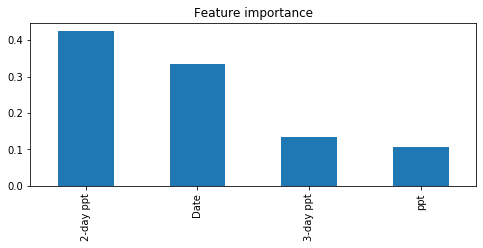

In [7]:
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score

# convert Sample date from timestamp to numeric because sklearn cannot process timestamp format
df_basemain['Date'] = pd.to_numeric(pd.to_datetime(df_basemain['Date']))

# implement random forest
from sklearn.model_selection import train_test_split

# change the input parameters (i.e., predictors) here 
predictors = ['Date', 'ppt', '2-day ppt', '3-day ppt']
X = df_basemain[predictors]

# change the output parameters (i.e., sub8 flow, sub11 flow, sub12 flow) here 
y = df_basemain['Sub8 baseflow']

X_train, X_test, Y_train, Y_test = train_test_split (X, y, test_size = 0.25, random_state = 0)

rf_base = ske.RandomForestRegressor(n_estimators = 500, random_state = 0)

rf_base.fit(X_train, Y_train)

Y_pred = rf_base.predict(X_test)

print('training period explained variance:', explained_variance_score(Y_test, Y_pred))
print('training period mean abs error:',mean_absolute_error(Y_test, Y_pred))
print('training period mean squared error:',mean_squared_error(Y_test, Y_pred))
print('training period r2:',r2_score(Y_test, Y_pred))

fet_ind = np.argsort(rf_base.feature_importances_)[::-1]
fet_imp = rf_base.feature_importances_[np.argsort(rf_base.feature_importances_)][::-1]

fig, ax = plt.subplots(1, 1, figsize=(8,3))
labels = np.asarray(X_train.columns[fet_ind])
pd.Series(fet_imp, index = labels).plot('bar', ax=ax)
ax.set_title('Feature importance')

### Using random grid model to improve base model

In [8]:
from sklearn.model_selection import RandomizedSearchCV
# the values below are somewhat selected arbitarily to cover a wide range of parameters

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [9]:
# Use the random grid to search for best hyperparameters
rf = ske.RandomForestRegressor()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=0, n_jobs = 1)
# Fit the random search model
rf_random.fit(X_train, Y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=True 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=True, total=   0.3s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=True 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=True, total=   0.2s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=True 
[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=True, total=   0.2s
[CV] n_estimators=1200, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=True 
[CV]  n_estimators=1200, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=True, total=   0.6s
[CV] n_estimators=1200, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=True 
[CV]  n_estimators=1200, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=True, total=   0.6s
[CV] n_estimators=1200, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=True 
[CV]  n_estimators=1200, min

[CV]  n_estimators=1800, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=100, bootstrap=False, total=   0.7s
[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=True 
[CV]  n_estimators=2000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=True, total=   0.8s
[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=True 
[CV]  n_estimators=2000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=True, total=   0.9s
[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=True 
[CV]  n_estimators=2000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=True, total=   1.0s
[CV] n_estimators=1800, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=None, bootstrap=True 
[CV]  n_estimator

[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=False, total=   0.1s
[CV] n_estimators=800, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=False 
[CV]  n_estimators=800, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=False, total=   0.4s
[CV] n_estimators=800, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=False 
[CV]  n_estimators=800, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=False, total=   0.3s
[CV] n_estimators=800, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=False 
[CV]  n_estimators=800, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=False, total=   0.3s
[CV] n_estimators=1800, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=110, bootstrap=True 
[CV]  n_estimators=1800, m

[CV]  n_estimators=2000, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=True, total=   0.9s
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=True 
[CV]  n_estimators=2000, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=True, total=   0.9s
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=True 
[CV]  n_estimators=2000, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=True, total=   0.9s
[CV] n_estimators=1400, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=100, bootstrap=False 
[CV]  n_estimators=1400, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=100, bootstrap=False, total=   0.7s
[CV] n_estimators=1400, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=100, bootstrap=False 
[CV]  n_estimators=140

[CV]  n_estimators=1200, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=None, bootstrap=True, total=   0.7s
[CV] n_estimators=1200, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=None, bootstrap=True 
[CV]  n_estimators=1200, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=None, bootstrap=True, total=   0.8s
[CV] n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=False 
[CV]  n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=False, total=   1.1s
[CV] n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=False 
[CV]  n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=False, total=   0.8s
[CV] n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=False 
[CV]  n_e

[CV]  n_estimators=600, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=10, bootstrap=True, total=   0.2s
[CV] n_estimators=600, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=50, bootstrap=False 
[CV]  n_estimators=600, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=50, bootstrap=False, total=   0.3s
[CV] n_estimators=600, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=50, bootstrap=False 
[CV]  n_estimators=600, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=50, bootstrap=False, total=   0.2s
[CV] n_estimators=600, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=50, bootstrap=False 
[CV]  n_estimators=600, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=50, bootstrap=False, total=   0.2s
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=False 
[CV]  n_estimators=1000, min

[CV]  n_estimators=1600, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=True, total=   0.8s
[CV] n_estimators=1600, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=True 
[CV]  n_estimators=1600, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=True, total=   0.8s
[CV] n_estimators=1600, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=True 
[CV]  n_estimators=1600, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=True, total=   0.7s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=30, bootstrap=True 
[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=30, bootstrap=True, total=   0.1s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=30, bootstrap=True 
[CV]  n_estimators

[CV]  n_estimators=1600, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=True, total=   0.8s
[CV] n_estimators=1600, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=True 
[CV]  n_estimators=1600, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=True, total=   0.9s
[CV] n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=50, bootstrap=False 
[CV]  n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=50, bootstrap=False, total=   0.7s
[CV] n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=50, bootstrap=False 
[CV]  n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=50, bootstrap=False, total=   0.7s
[CV] n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=50, bootstrap=False 
[CV]  n_estimat

[CV]  n_estimators=1800, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=True, total=   1.1s
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=110, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=110, bootstrap=True, total=   0.6s
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=110, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=110, bootstrap=True, total=   0.5s
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=110, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=110, bootstrap=True, total=   0.5s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=20, bootstrap=True 
[CV]  n_estimato

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  2.4min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...


In [10]:
Y_pred = rf_random.predict(X_test)

print('training period explained variance:', explained_variance_score(Y_test, Y_pred))
print('training period mean abs error:',mean_absolute_error(Y_test, Y_pred))
print('training period mean squared error:',mean_squared_error(Y_test, Y_pred))
print('training period r2:',r2_score(Y_test, Y_pred))

training period explained variance: -0.8101588689653372
training period mean abs error: 0.032686014135592655
training period mean squared error: 0.0033062104417487395
training period r2: -1.5470273858645425


In [1]:
def evaluate(model, X_train, Y_train):
    predictions = model.predict(X_train)
    errors = abs(predictions - Y_train)
    mape = 100 * np.mean(errors / Y_train)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} cms.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

class color:
    BLUE = '\033[94m'
    BOLD = '\033[1m'
    END = '\033[0m'

print(color.BOLD + color.BLUE + 'For Base Model' + color.END)
base_accuracy = evaluate(rf_base, X_train, Y_train)

print(color.BOLD + color.BLUE + 'For Random Model' + color.END)
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_train, Y_train)

print(color.BOLD + color.BLUE + 'Base vs random model comparison' + color.END)
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

pprint(rf_random.best_params_)

For Base Model


NameError: name 'rf_base' is not defined

In [12]:
from sklearn.model_selection import GridSearchCV

# if the random model performed better than the base model, then use the best random grid to create range of each hyperparameter

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 3, 4]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3]

# Method of selecting samples for training each tree
bootstrap = [False]

# Create the better grid
better_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# We used randamized search to identify the better grid (i.e., narrow down the range for each hyperparameter)
# Now we use the better grid to instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = better_grid, 
                          cv = 3, n_jobs = 1, verbose = 2)


In [13]:
# Fit the grid search to the data
grid_search.fit(X_train, Y_train)
grid_search.best_params_

best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_train, Y_train)

print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

Fitting 3 folds for each of 1080 candidates, totalling 3240 fits
[CV] bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, total=   0.1s
[CV] bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, total=   0.1s
[CV] bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, total=   0.1s
[CV] bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400 
[CV]  bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400, total=   0.2s
[CV] bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400 
[CV]  bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400, total=   0.2s
[CV] bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400 
[CV]  bootstrap=False, max_d

[CV]  bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=400, total=   0.2s
[CV] bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=600 
[CV]  bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=600, total=   0.3s
[CV] bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=600 
[CV]  bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=600, total=   0.3s
[CV] bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=600 
[CV]  bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=600, total=   0.2s
[CV] bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=800 
[CV]  bootstrap=False, max_d

[CV]  bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=800, total=   0.3s
[CV] bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=800 
[CV]  bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=800, total=   0.3s
[CV] bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=800 
[CV]  bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=800, total=   0.4s
[CV] bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1000 
[CV]  bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1000, total=   0.4s
[CV] bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1000 
[CV]  bootstrap=False, ma

[CV]  bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1000, total=   0.4s
[CV] bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1000 
[CV]  bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1000, total=   0.4s
[CV] bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1200 
[CV]  bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1200, total=   0.5s
[CV] bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1200 
[CV]  bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1200, total=   0.5s
[CV] bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1200 
[CV]  bootstrap=Fals

[CV]  bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=1200, total=   0.5s
[CV] bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=1400 
[CV]  bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=1400, total=   0.5s
[CV] bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=1400 
[CV]  bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=1400, total=   0.6s
[CV] bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=1400 
[CV]  bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=1400, total=   0.6s
[CV] bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=1600 
[CV]  bootstrap=Fals

[CV]  bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1600, total=   0.7s
[CV] bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1600 
[CV]  bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1600, total=   0.7s
[CV] bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1600 
[CV]  bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1600, total=   0.8s
[CV] bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1800 
[CV]  bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1800, total=   0.9s
[CV] bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1800 
[CV]  bootstrap=Fals

[CV]  bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=1800, total=   0.8s
[CV] bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=1800 
[CV]  bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=1800, total=   0.9s
[CV] bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=2000 
[CV]  bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=2000, total=   0.9s
[CV] bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=2000 
[CV]  bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=2000, total=   1.0s
[CV] bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=2000 
[CV]  bootstrap=Fals

[CV]  bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=2000, total=   1.0s
[CV] bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=200 
[CV]  bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=200, total=   0.1s
[CV] bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=200 
[CV]  bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=200, total=   0.1s
[CV] bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=200 
[CV]  bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=200, total=   0.1s
[CV] bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=400 
[CV]  bootstrap=False, max_

[CV]  bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400, total=   0.2s
[CV] bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400 
[CV]  bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400, total=   0.2s
[CV] bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400 
[CV]  bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400, total=   0.3s
[CV] bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=600 
[CV]  bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=600, total=   0.5s
[CV] bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=600 
[CV]  bootstrap=False, max_d

[CV]  bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=600, total=   0.2s
[CV] bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=600 
[CV]  bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=600, total=   0.3s
[CV] bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=800 
[CV]  bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=800, total=   0.3s
[CV] bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=800 
[CV]  bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=800, total=   0.3s
[CV] bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=800 
[CV]  bootstrap=False, max_d

[CV]  bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=800, total=   0.3s
[CV] bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1000 
[CV]  bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1000, total=   0.4s
[CV] bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1000 
[CV]  bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1000, total=   0.6s
[CV] bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1000 
[CV]  bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1000, total=   0.4s
[CV] bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1200 
[CV]  bootstrap=False

[CV]  bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1200, total=   0.5s
[CV] bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1200 
[CV]  bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1200, total=   0.6s
[CV] bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1200 
[CV]  bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1200, total=   0.6s
[CV] bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1400 
[CV]  bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1400, total=   0.7s
[CV] bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1400 
[CV]  bootstrap=Fals

[CV]  bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=1400, total=   0.6s
[CV] bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=1400 
[CV]  bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=1400, total=   0.6s
[CV] bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=1600 
[CV]  bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=1600, total=   0.7s
[CV] bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=1600 
[CV]  bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=1600, total=   0.8s
[CV] bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=1600 
[CV]  bootstrap=Fals

[CV]  bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1600, total=   0.7s
[CV] bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1800 
[CV]  bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1800, total=   0.7s
[CV] bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1800 
[CV]  bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1800, total=   0.7s
[CV] bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1800 
[CV]  bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1800, total=   0.8s
[CV] bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=2000 
[CV]  bootstrap=Fals

[CV]  bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=2000, total=   0.9s
[CV] bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=2000 
[CV]  bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=2000, total=   0.8s
[CV] bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=2000 
[CV]  bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=2000, total=   0.9s
[CV] bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200 
[CV]  bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, total=   0.1s
[CV] bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200 
[CV]  bootstrap=False, 

[CV]  bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=200, total=   0.1s
[CV] bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=200 
[CV]  bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=200, total=   0.1s
[CV] bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=400 
[CV]  bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=400, total=   0.2s
[CV] bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=400 
[CV]  bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=400, total=   0.3s
[CV] bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=400 
[CV]  bootstrap=False, max_d

[CV]  bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=600, total=   0.3s
[CV] bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=600 
[CV]  bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=600, total=   0.3s
[CV] bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=600 
[CV]  bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=600, total=   0.3s
[CV] bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=800 
[CV]  bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=800, total=   0.3s
[CV] bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=800 
[CV]  bootstrap=False, max_d

[CV]  bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=800, total=   0.3s
[CV] bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=800 
[CV]  bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=800, total=   0.3s
[CV] bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=1000 
[CV]  bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=1000, total=   0.4s
[CV] bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=1000 
[CV]  bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=1000, total=   0.4s
[CV] bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=1000 
[CV]  bootstrap=False, 

[CV]  bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1000, total=   0.4s
[CV] bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1200 
[CV]  bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1200, total=   0.5s
[CV] bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1200 
[CV]  bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1200, total=   0.5s
[CV] bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1200 
[CV]  bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1200, total=   0.6s
[CV] bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1400 
[CV]  bootstrap=Fals

[CV]  bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1400, total=   0.6s
[CV] bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1400 
[CV]  bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1400, total=   0.7s
[CV] bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1400 
[CV]  bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1400, total=   0.7s
[CV] bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1600 
[CV]  bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1600, total=   0.8s
[CV] bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1600 
[CV]  bootstrap=Fals

[CV]  bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=1600, total=   0.7s
[CV] bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=1600 
[CV]  bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=1600, total=   0.7s
[CV] bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=1800 
[CV]  bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=1800, total=   0.7s
[CV] bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=1800 
[CV]  bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=1800, total=   0.8s
[CV] bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=1800 
[CV]  bootstrap=Fals

[CV]  bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1800, total=   0.7s
[CV] bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=2000 
[CV]  bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=2000, total=   0.8s
[CV] bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=2000 
[CV]  bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=2000, total=   0.9s
[CV] bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=2000 
[CV]  bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=2000, total=   0.8s
[CV] bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=False

[CV]  bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=200, total=   0.1s
[CV] bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=400 
[CV]  bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=400, total=   0.2s
[CV] bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=400 
[CV]  bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=400, total=   0.2s
[CV] bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=400 
[CV]  bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=400, total=   0.2s
[CV] bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=600 
[CV]  bootstrap=False, max_d

[CV]  bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=600, total=   0.3s
[CV] bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=600 
[CV]  bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=600, total=   0.3s
[CV] bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=600 
[CV]  bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=600, total=   0.3s
[CV] bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=800 
[CV]  bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=800, total=   0.4s
[CV] bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=800 
[CV]  bootstrap=False, max_d

[CV]  bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=800, total=   0.4s
[CV] bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=800 
[CV]  bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=800, total=   0.4s
[CV] bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1000 
[CV]  bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1000, total=   0.4s
[CV] bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1000 
[CV]  bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1000, total=   0.4s
[CV] bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1000 
[CV]  bootstrap=False, 

[CV]  bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=1000, total=   0.5s
[CV] bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=1200 
[CV]  bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=1200, total=   0.5s
[CV] bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=1200 
[CV]  bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=1200, total=   0.6s
[CV] bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=1200 
[CV]  bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=1200, total=   0.5s
[CV] bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=1400 
[CV]  bootstrap=Fals

[CV]  bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1400, total=   0.6s
[CV] bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1400 
[CV]  bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1400, total=   0.6s
[CV] bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1400 
[CV]  bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1400, total=   0.6s
[CV] bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1600 
[CV]  bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1600, total=   0.7s
[CV] bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1600 
[CV]  bootstrap=Fals

[CV]  bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1600, total=   0.9s
[CV] bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1600 
[CV]  bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1600, total=   0.8s
[CV] bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1800 
[CV]  bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1800, total=   1.0s
[CV] bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1800 
[CV]  bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1800, total=   0.8s
[CV] bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1800 
[CV]  bootstrap=Fals

[CV]  bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=1800, total=   0.9s
[CV] bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=2000 
[CV]  bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=2000, total=   0.8s
[CV] bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=2000 
[CV]  bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=2000, total=   0.8s
[CV] bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=2000 
[CV]  bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=2000, total=   0.9s
[CV] bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=200 
[CV]  bootstrap=False

[CV]  bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200, total=   0.1s
[CV] bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=400 
[CV]  bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=400, total=   0.2s
[CV] bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=400 
[CV]  bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=400, total=   0.2s
[CV] bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=400 
[CV]  bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=400, total=   0.2s
[CV] bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=600 
[CV]  bootstrap=False, max_d

[CV]  bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=600, total=   0.3s
[CV] bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=600 
[CV]  bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=600, total=   0.3s
[CV] bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=600 
[CV]  bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=600, total=   0.3s
[CV] bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=800 
[CV]  bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=800, total=   0.4s
[CV] bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=800 
[CV]  bootstrap=False, max_d

[CV]  bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=800, total=   0.3s
[CV] bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=800 
[CV]  bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=800, total=   0.3s
[CV] bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=1000 
[CV]  bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=1000, total=   0.4s
[CV] bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=1000 
[CV]  bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=1000, total=   0.4s
[CV] bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=1000 
[CV]  bootstrap=False, 

[CV]  bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1000, total=   0.5s
[CV] bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1200 
[CV]  bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1200, total=   0.5s
[CV] bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1200 
[CV]  bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1200, total=   0.5s
[CV] bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1200 
[CV]  bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1200, total=   0.5s
[CV] bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1400 
[CV]  bootstrap=Fals

[CV]  bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=1400, total=   0.5s
[CV] bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=1400 
[CV]  bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=1400, total=   0.6s
[CV] bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=1400 
[CV]  bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=1400, total=   0.6s
[CV] bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=1600 
[CV]  bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=1600, total=   0.8s
[CV] bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=1600 
[CV]  bootstrap=Fals

[CV]  bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1600, total=   0.7s
[CV] bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1600 
[CV]  bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1600, total=   0.7s
[CV] bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1800 
[CV]  bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1800, total=   0.8s
[CV] bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1800 
[CV]  bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1800, total=   0.8s
[CV] bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1800 
[CV]  bootstrap=Fals

[CV]  bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1800, total=   0.8s
[CV] bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=2000 
[CV]  bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=2000, total=   0.8s
[CV] bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=2000 
[CV]  bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=2000, total=   0.8s
[CV] bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=2000 
[CV]  bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=2000, total=   0.8s
[CV] bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200 
[CV]  bootstrap=False

[CV]  bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=200, total=   0.1s
[CV] bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=200 
[CV]  bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=200, total=   0.1s
[CV] bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=400 
[CV]  bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=400, total=   0.2s
[CV] bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=400 
[CV]  bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=400, total=   0.2s
[CV] bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=400 
[CV]  bootstrap=False, max_d

[CV]  bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=400, total=   0.2s
[CV] bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=600 
[CV]  bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=600, total=   0.3s
[CV] bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=600 
[CV]  bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=600, total=   0.3s
[CV] bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=600 
[CV]  bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=600, total=   0.2s
[CV] bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=800 
[CV]  bootstrap=False, max_d

[CV]  bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=800, total=   0.3s
[CV] bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=800 
[CV]  bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=800, total=   0.3s
[CV] bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=800 
[CV]  bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=800, total=   0.3s
[CV] bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=1000 
[CV]  bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=1000, total=   0.4s
[CV] bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=1000 
[CV]  bootstrap=False, ma

[CV]  bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=1000, total=   0.4s
[CV] bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=1000 
[CV]  bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=1000, total=   0.4s
[CV] bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=1200 
[CV]  bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=1200, total=   0.5s
[CV] bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=1200 
[CV]  bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=1200, total=   0.5s
[CV] bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=1200 
[CV]  bootstrap=Fals

[CV]  bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1200, total=   0.5s
[CV] bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1400 
[CV]  bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1400, total=   0.6s
[CV] bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1400 
[CV]  bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1400, total=   0.6s
[CV] bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1400 
[CV]  bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1400, total=   0.6s
[CV] bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1600 
[CV]  bootstrap=Fals

[CV]  bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=1600, total=   0.7s
[CV] bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=1600 
[CV]  bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=1600, total=   0.7s
[CV] bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=1600 
[CV]  bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=1600, total=   0.6s
[CV] bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=1800 
[CV]  bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=1800, total=   0.8s
[CV] bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=1800 
[CV]  bootstrap=Fals

[CV]  bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1800, total=   0.7s
[CV] bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1800 
[CV]  bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1800, total=   0.7s
[CV] bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=2000 
[CV]  bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=2000, total=   0.8s
[CV] bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=2000 
[CV]  bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=2000, total=   0.9s
[CV] bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=2000 
[CV]  bootstrap=Fals

[CV]  bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=2000, total=   0.8s
[CV] bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200 
[CV]  bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, total=   0.1s
[CV] bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200 
[CV]  bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, total=   0.1s
[CV] bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200 
[CV]  bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, total=   0.1s
[CV] bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=400 
[CV]  bootstrap=False, max_

[CV]  bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=400, total=   0.2s
[CV] bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=400 
[CV]  bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=400, total=   0.2s
[CV] bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=400 
[CV]  bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=400, total=   0.2s
[CV] bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=600 
[CV]  bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=600, total=   0.2s
[CV] bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=600 
[CV]  bootstrap=False, max_d

[CV]  bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=600, total=   0.3s
[CV] bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=600 
[CV]  bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=600, total=   0.3s
[CV] bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=800 
[CV]  bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=800, total=   0.4s
[CV] bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=800 
[CV]  bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=800, total=   0.4s
[CV] bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=800 
[CV]  bootstrap=False, max_d

[CV]  bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=800, total=   0.3s
[CV] bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=1000 
[CV]  bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=1000, total=   0.4s
[CV] bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=1000 
[CV]  bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=1000, total=   0.4s
[CV] bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=1000 
[CV]  bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=1000, total=   0.4s
[CV] bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=1200 
[CV]  bootstrap=False

[CV]  bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=1200, total=   0.5s
[CV] bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=1200 
[CV]  bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=1200, total=   0.5s
[CV] bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=1200 
[CV]  bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=1200, total=   0.6s
[CV] bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=1400 
[CV]  bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=1400, total=   0.7s
[CV] bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=1400 
[CV]  bootstrap=Fals

[CV]  bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1400, total=   0.6s
[CV] bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1400 
[CV]  bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1400, total=   0.6s
[CV] bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1600 
[CV]  bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1600, total=   0.7s
[CV] bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1600 
[CV]  bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1600, total=   0.7s
[CV] bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1600 
[CV]  bootstrap=Fals

[CV]  bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=1600, total=   0.8s
[CV] bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=1800 
[CV]  bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=1800, total=   0.9s
[CV] bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=1800 
[CV]  bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=1800, total=   0.9s
[CV] bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=1800 
[CV]  bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=1800, total=   0.7s
[CV] bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=2000 
[CV]  bootstrap=Fals

[CV]  bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=2000, total=   0.8s
[CV] bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=2000 
[CV]  bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=2000, total=   0.9s
[CV] bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=2000 
[CV]  bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=2000, total=   0.8s
[CV] bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, total=   0.1s
[CV] bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=False, 

[CV]  bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=200, total=   0.1s
[CV] bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=400 
[CV]  bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=400, total=   0.2s
[CV] bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=400 
[CV]  bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=400, total=   0.2s
[CV] bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=400 
[CV]  bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=400, total=   0.2s
[CV] bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=600 
[CV]  bootstrap=False, max_d

[CV]  bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=600, total=   0.3s
[CV] bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=600 
[CV]  bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=600, total=   0.3s
[CV] bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=600 
[CV]  bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=600, total=   0.2s
[CV] bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=800 
[CV]  bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=800, total=   0.4s
[CV] bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=800 
[CV]  bootstrap=False, max_d

[CV]  bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=800, total=   0.3s
[CV] bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=800 
[CV]  bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=800, total=   0.4s
[CV] bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=1000 
[CV]  bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=1000, total=   0.4s
[CV] bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=1000 
[CV]  bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=1000, total=   0.4s
[CV] bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=1000 
[CV]  bootstrap=False, 

[CV]  bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=1000, total=   0.6s
[CV] bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=1200 
[CV]  bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=1200, total=   0.6s
[CV] bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=1200 
[CV]  bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=1200, total=   0.8s
[CV] bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=1200 
[CV]  bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=1200, total=   0.7s
[CV] bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=1400 
[CV]  bootstrap=Fals

[CV]  bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=1400, total=   0.6s
[CV] bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=1400 
[CV]  bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=1400, total=   0.6s
[CV] bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=1400 
[CV]  bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=1400, total=   0.7s
[CV] bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=1600 
[CV]  bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=1600, total=   0.8s
[CV] bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=1600 
[CV]  bootstrap=Fals

[CV]  bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1600, total=   0.8s
[CV] bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1600 
[CV]  bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1600, total=   0.7s
[CV] bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1800 
[CV]  bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1800, total=   0.9s
[CV] bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1800 
[CV]  bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1800, total=   0.9s
[CV] bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1800 
[CV]  bootstrap=Fals

[CV]  bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=1800, total=   1.0s
[CV] bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=2000 
[CV]  bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=2000, total=   1.0s
[CV] bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=2000 
[CV]  bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=2000, total=   1.0s
[CV] bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=2000 
[CV]  bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=2000, total=   0.9s
[CV] bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=200 
[CV]  bootstrap=False

[CV]  bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, total=   0.1s
[CV] bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, total=   0.1s
[CV] bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400 
[CV]  bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400, total=   0.2s
[CV] bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400 
[CV]  bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400, total=   0.2s
[CV] bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400 
[CV]  bootstrap=False, max_d

[CV]  bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=400, total=   0.2s
[CV] bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=600 
[CV]  bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=600, total=   0.3s
[CV] bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=600 
[CV]  bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=600, total=   0.3s
[CV] bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=600 
[CV]  bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=600, total=   0.3s
[CV] bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=800 
[CV]  bootstrap=False, max_d

[CV]  bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=800, total=   0.4s
[CV] bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=800 
[CV]  bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=800, total=   0.4s
[CV] bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=800 
[CV]  bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=800, total=   0.4s
[CV] bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1000 
[CV]  bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1000, total=   0.4s
[CV] bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1000 
[CV]  bootstrap=False, ma

[CV]  bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=1000, total=   0.4s
[CV] bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=1000 
[CV]  bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=1000, total=   0.4s
[CV] bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=1200 
[CV]  bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=1200, total=   0.6s
[CV] bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=1200 
[CV]  bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=1200, total=   0.6s
[CV] bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=1200 
[CV]  bootstrap=Fals

[CV]  bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=1200, total=   0.6s
[CV] bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=1400 
[CV]  bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=1400, total=   0.7s
[CV] bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=1400 
[CV]  bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=1400, total=   0.8s
[CV] bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=1400 
[CV]  bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=1400, total=   0.7s
[CV] bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=1600 
[CV]  bootstrap=Fals

[CV]  bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=1600, total=   0.8s
[CV] bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=1600 
[CV]  bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=1600, total=   0.7s
[CV] bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=1600 
[CV]  bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=1600, total=   0.8s
[CV] bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=1800 
[CV]  bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=1800, total=   0.9s
[CV] bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=1800 
[CV]  bootstrap=Fals

[CV]  bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1800, total=   0.9s
[CV] bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1800 
[CV]  bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1800, total=   0.9s
[CV] bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=2000 
[CV]  bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=2000, total=   1.0s
[CV] bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=2000 
[CV]  bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=2000, total=   1.0s
[CV] bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=2000 
[CV]  bootstrap=Fals

[CV]  bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=2000, total=   1.0s
[CV] bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=200 
[CV]  bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=200, total=   0.1s
[CV] bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=200 
[CV]  bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=200, total=   0.1s
[CV] bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=200 
[CV]  bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=200, total=   0.1s
[CV] bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=400 
[CV]  bootstrap=False, max_

[CV]  bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400, total=   0.2s
[CV] bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400 
[CV]  bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400, total=   0.2s
[CV] bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400 
[CV]  bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400, total=   0.2s
[CV] bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=600 
[CV]  bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=600, total=   0.3s
[CV] bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=600 
[CV]  bootstrap=False, max_d

[CV]  bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=600, total=   0.3s
[CV] bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=600 
[CV]  bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=600, total=   0.3s
[CV] bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=800 
[CV]  bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=800, total=   0.4s
[CV] bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=800 
[CV]  bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=800, total=   0.4s
[CV] bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=800 
[CV]  bootstrap=False, max_d

[CV]  bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=800, total=   0.4s
[CV] bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1000 
[CV]  bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1000, total=   0.4s
[CV] bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1000 
[CV]  bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1000, total=   0.5s
[CV] bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1000 
[CV]  bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1000, total=   0.5s
[CV] bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1200 
[CV]  bootstrap=False

[CV]  bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=1200, total=   0.6s
[CV] bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=1200 
[CV]  bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=1200, total=   0.6s
[CV] bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=1200 
[CV]  bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=1200, total=   0.6s
[CV] bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=1400 
[CV]  bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=1400, total=   0.7s
[CV] bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=1400 
[CV]  bootstrap=Fals

[CV]  bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=1400, total=   0.7s
[CV] bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=1400 
[CV]  bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=1400, total=   0.7s
[CV] bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=1600 
[CV]  bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=1600, total=   1.0s
[CV] bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=1600 
[CV]  bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=1600, total=   0.8s
[CV] bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=1600 
[CV]  bootstrap=Fals

[CV]  bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=1600, total=   0.8s
[CV] bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=1800 
[CV]  bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=1800, total=   0.8s
[CV] bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=1800 
[CV]  bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=1800, total=   0.9s
[CV] bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=1800 
[CV]  bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=1800, total=   0.9s
[CV] bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=2000 
[CV]  bootstrap=Fals

[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=2000, total=   1.0s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=2000 
[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=2000, total=   1.0s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=2000 
[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=2000, total=   0.9s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200 
[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, total=   0.1s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200 
[CV]  bootstrap

[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=200, total=   0.1s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=200 
[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=200, total=   0.1s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=400 
[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=400, total=   0.2s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=400 
[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=400, total=   0.2s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=400 
[CV]  bootstrap=Fals

[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400, total=   0.2s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=600 
[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=600, total=   0.3s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=600 
[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=600, total=   0.3s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=600 
[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=600, total=   0.3s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=800 
[CV]  bootstrap=Fals

[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=800, total=   0.3s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=800 
[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=800, total=   0.4s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=800 
[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=800, total=   0.4s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=1000 
[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=1000, total=   0.5s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=1000 
[CV]  bootstrap=F

[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1000, total=   0.5s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1000 
[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1000, total=   0.4s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1200 
[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1200, total=   0.5s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1200 
[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1200, total=   0.7s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1200 
[CV]  bootst

[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=1200, total=   0.5s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=1400 
[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=1400, total=   0.6s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=1400 
[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=1400, total=   0.6s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=1400 
[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=1400, total=   0.6s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=1600 
[CV]  bootst

[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=1600, total=   1.1s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=1600 
[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=1600, total=   1.2s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=1600 
[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=1600, total=   0.7s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=1800 
[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=1800, total=   0.8s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=1800 
[CV]  bootst

[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=1800, total=   0.7s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=1800 
[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=1800, total=   0.7s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=2000 
[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=2000, total=   0.7s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=2000 
[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=2000, total=   0.7s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=2000 
[CV]  bootst

[CV]  bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=2000, total=   0.8s
[CV] bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200 
[CV]  bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, total=   0.1s
[CV] bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200 
[CV]  bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, total=   0.1s
[CV] bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200 
[CV]  bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, total=   0.1s
[CV] bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=400 
[CV]  bootstrap=Fal

[CV]  bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=400, total=   0.2s
[CV] bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=400 
[CV]  bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=400, total=   0.1s
[CV] bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=600 
[CV]  bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=600, total=   0.2s
[CV] bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=600 
[CV]  bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=600, total=   0.3s
[CV] bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=600 
[CV]  bootstrap=Fals

[CV]  bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=600, total=   0.3s
[CV] bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=800 
[CV]  bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=800, total=   0.4s
[CV] bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=800 
[CV]  bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=800, total=   0.3s
[CV] bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=800 
[CV]  bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=800, total=   0.3s
[CV] bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1000 
[CV]  bootstrap=Fal

[CV]  bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=1000, total=   0.5s
[CV] bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=1000 
[CV]  bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=1000, total=   0.4s
[CV] bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=1000 
[CV]  bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=1000, total=   0.4s
[CV] bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=1200 
[CV]  bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=1200, total=   0.6s
[CV] bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=1200 
[CV]  bootst

[CV]  bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1200, total=   0.5s
[CV] bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1200 
[CV]  bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1200, total=   0.5s
[CV] bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1400 
[CV]  bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1400, total=   0.6s
[CV] bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1400 
[CV]  bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1400, total=   0.6s
[CV] bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1400 
[CV]  bootst

[CV]  bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=1400, total=   0.6s
[CV] bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=1600 
[CV]  bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=1600, total=   0.7s
[CV] bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=1600 
[CV]  bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=1600, total=   0.6s
[CV] bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=1600 
[CV]  bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=1600, total=   0.6s
[CV] bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=1800 
[CV]  bootst

[CV]  bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=1800, total=   0.7s
[CV] bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=1800 
[CV]  bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=1800, total=   0.7s
[CV] bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=1800 
[CV]  bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=1800, total=   0.7s
[CV] bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=2000 
[CV]  bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=2000, total=   0.8s
[CV] bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=2000 
[CV]  bootst

[CV]  bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=2000, total=   0.8s
[CV] bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=2000 
[CV]  bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=2000, total=   0.8s
[CV] bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, total=   0.1s
[CV] bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, total=   0.1s
[CV] bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200 
[CV]  bootst

[CV]  bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=200, total=   0.1s
[CV] bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=400 
[CV]  bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=400, total=   0.2s
[CV] bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=400 
[CV]  bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=400, total=   0.2s
[CV] bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=400 
[CV]  bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=400, total=   0.2s
[CV] bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=600 
[CV]  bootst

[CV]  bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=600, total=   0.2s
[CV] bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=600 
[CV]  bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=600, total=   0.2s
[CV] bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=600 
[CV]  bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=600, total=   0.2s
[CV] bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=800 
[CV]  bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=800, total=   0.3s
[CV] bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=800 
[CV]  bootst

[CV]  bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=800, total=   0.4s
[CV] bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=800 
[CV]  bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=800, total=   0.3s
[CV] bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1000 
[CV]  bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1000, total=   0.4s
[CV] bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1000 
[CV]  bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1000, total=   0.4s
[CV] bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1000 
[CV]  b

[CV]  bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=1000, total=   0.4s
[CV] bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=1200 
[CV]  bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=1200, total=   0.5s
[CV] bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=1200 
[CV]  bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=1200, total=   0.5s
[CV] bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=1200 
[CV]  bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=1200, total=   0.9s
[CV] bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=1400 
[CV]

[CV]  bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1200, total=   0.5s
[CV] bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1400 
[CV]  bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1400, total=   0.6s
[CV] bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1400 
[CV]  bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1400, total=   0.6s
[CV] bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1400 
[CV]  bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1400, total=   0.6s
[CV] bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1600 
[CV]

[CV]  bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=1400, total=   0.7s
[CV] bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=1600 
[CV]  bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=1600, total=   0.7s
[CV] bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=1600 
[CV]  bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=1600, total=   0.6s
[CV] bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=1600 
[CV]  bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=1600, total=   0.6s
[CV] bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=1800 
[CV]

[CV]  bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=1600, total=   0.7s
[CV] bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=1800 
[CV]  bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=1800, total=   0.8s
[CV] bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=1800 
[CV]  bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=1800, total=   0.7s
[CV] bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=1800 
[CV]  bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=1800, total=   0.7s
[CV] bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=2000 
[CV]

[CV]  bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=1800, total=   0.8s
[CV] bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=2000 
[CV]  bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=2000, total=   0.8s
[CV] bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=2000 
[CV]  bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=2000, total=   0.9s
[CV] bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=2000 
[CV]  bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=2000, total=   0.9s
Model Performance
Average Error: 0.0000 cms.
Accuracy = 100.00%.
Improvement of 46.32%.


[Parallel(n_jobs=1)]: Done 3240 out of 3240 | elapsed: 26.8min finished


In [14]:
Y_pred = rf_random.predict(X_test)

print('training period explained variance:', explained_variance_score(Y_test, Y_pred))
print('training period mean abs error:',mean_absolute_error(Y_test, Y_pred))
print('training period mean squared error:',mean_squared_error(Y_test, Y_pred))
print('training period r2:',r2_score(Y_test, Y_pred))

training period explained variance: -0.8101588689653372
training period mean abs error: 0.032686014135592655
training period mean squared error: 0.0033062104417487395
training period r2: -1.5470273858645425


## Predict 2018 data, then compare against actual flow data

prediction period explained variance: -15.336658574720754
prediction period mean abs error: 0.06310590489740654
prediction period mean squared error: 0.008586296452748754
prediction period r2: -19.384277240990077


Text(0, 0.5, 'Predicted flow (cms)')

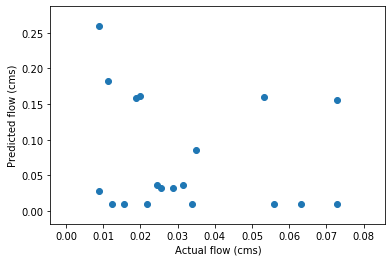

In [19]:
df_test = pd.read_excel('Test data 2018.xlsx', sheet_name = 'By subwatershed')
df_test = df_test[(df_test['Site'] == 'Sub8') & (df_test['Sample type'] == 'Base')]

df_test = pd.merge(df_weather, df_test, left_on='Date', right_on='Sample date', how='inner')

df_test = df_test[predictors]

# convert Sample date from timestamp to numeric because sklearn cannot process timestamp format
df_test['Date'] = pd.to_numeric(pd.to_datetime(df_test['Date']))

Y_pred = rf_random.predict(df_test)

df_predict = pd.DataFrame(Y_pred, columns=['flow_pred'])
df_predict = pd.merge(df_test, df_predict, left_index=True, right_index=True)

df_actual = pd.read_excel('Test data 2018.xlsx', sheet_name = 'By subwatershed_full')
df_actual = df_actual[['Sample date','Flow (cms)']]
df_actual['day of year'] = df_actual['Sample date'].dt.dayofyear

df_predict = pd.merge(df_actual, df_predict['flow_pred'], left_index=True, right_index=True)
df_predict['error (%)'] = round(((df_predict['Flow (cms)']-df_predict['flow_pred'])/df_predict['Flow (cms)']*100), 0)

print('prediction period explained variance:',explained_variance_score(df_predict['Flow (cms)'], df_predict['flow_pred']))
print('prediction period mean abs error:',mean_absolute_error(df_predict['Flow (cms)'], df_predict['flow_pred']))
print('prediction period mean squared error:',mean_squared_error(df_predict['Flow (cms)'], df_predict['flow_pred']))
print('prediction period r2:',r2_score(df_predict['Flow (cms)'], df_predict['flow_pred']))

plt.scatter(df_predict['Flow (cms)'], df_predict['flow_pred'])
plt.xlabel('Actual flow (cms)')
plt.ylabel('Predicted flow (cms)')

In [16]:
writer = pd.ExcelWriter('predict flow 2018.xlsx')
# write dataframe to excel
df_predict.to_excel(writer)
# save the excel
writer.save()

## Predict 2018 daily data

Text(0, 0.5, 'Predicted flow (cms)')

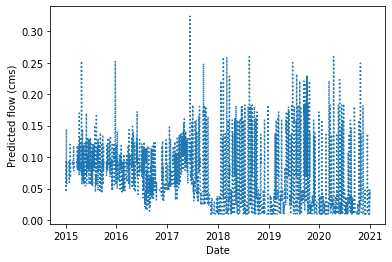

In [20]:
df_weathersub = df_weather[df_weather["Year"].isin([2015, 2016, 2017, 2018, 2019, 2020])]
df_test = df_weathersub
df_test = df_test[predictors]
df_test = df_test.dropna()
df_test = df_test.reset_index(drop=True)

# convert Sample date from timestamp to numeric because sklearn cannot process timestamp format
df_test['Date'] = pd.to_numeric(pd.to_datetime(df_test['Date']))

Y_pred = rf_random.predict(df_test)

df_predict = pd.DataFrame(Y_pred, columns=['flow_pred'])
df_weathersub = df_weathersub[predictors]
df_predict = pd.merge(df_test, df_predict, left_index=True, right_index=True)

df_predict['Date'] = pd.to_datetime(df_predict['Date'])

plt.plot(df_predict['Date'], df_predict['flow_pred'], linestyle = 'dotted')
plt.xlabel('Date')
plt.ylabel('Predicted flow (cms)')

In [21]:
writer = pd.ExcelWriter('predict flow 2015-18 daily.xlsx')
# write dataframe to excel
df_predict.to_excel(writer)
# save the excel
writer.save()